
Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from pathlib import Path

In [2]:
# Plot settings

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12,6)

In [3]:
# Load data

data_path = Path("../data/final/ibm_df.csv")
df = pd.read_csv(data_path, parse_dates=["Date"])
print(df.head(2))

        Date       Close   Volume    Return  Return_lag  Return_3d_sum  \
0 2020-12-07  119.216064  8701151 -0.019654    0.029043       0.032793   
1 2020-12-10  119.464630  5024147 -0.014433    0.008591      -0.002963   

   Return_7d_sum  Volatility_3d  Volatility_7d DayOfWeek  Interest  \
0       0.022643       0.025445       0.015744    Monday        44   
1       0.026915       0.013154       0.017078  Thursday        46   

   Interest_lag  Sentiment  Prev_sentiment  
0          21.0     0.2997        0.158033  
1          47.0     0.0000        0.299700  



EDA

In [4]:
# Shape

rows, cols = df.shape
print(f"Dataset Shape: Rows={rows:,}, Columns={cols}")

Dataset Shape: Rows=359, Columns=14


In [5]:
# Columns

print(df.columns.tolist())

['Date', 'Close', 'Volume', 'Return', 'Return_lag', 'Return_3d_sum', 'Return_7d_sum', 'Volatility_3d', 'Volatility_7d', 'DayOfWeek', 'Interest', 'Interest_lag', 'Sentiment', 'Prev_sentiment']


In [6]:
# Missing Values (should all be 0)

print("\nMissing values:\n", df.isna().sum())


Missing values:
 Date              0
Close             0
Volume            0
Return            0
Return_lag        0
Return_3d_sum     0
Return_7d_sum     0
Volatility_3d     0
Volatility_7d     0
DayOfWeek         0
Interest          0
Interest_lag      0
Sentiment         0
Prev_sentiment    0
dtype: int64


In [7]:
# Summary Stats

print(df.describe())

                                Date       Close        Volume      Return  \
count                            359  359.000000  3.590000e+02  359.000000   
mean   2023-02-25 20:15:22.562674176  160.795861  5.282661e+06    0.001307   
min              2020-12-07 00:00:00  113.393883  1.790400e+06   -0.099050   
25%              2021-11-11 00:00:00  128.308701  3.440150e+06   -0.006211   
50%              2023-03-03 00:00:00  137.600006  4.455960e+06    0.001532   
75%              2024-04-25 12:00:00  173.209999  5.719540e+06    0.008724   
max              2025-11-20 00:00:00  312.570007  3.981442e+07    0.129642   
std                              NaN   49.692956  3.588688e+06    0.017289   

       Return_lag  Return_3d_sum  Return_7d_sum  Volatility_3d  Volatility_7d  \
count  359.000000     359.000000     359.000000     359.000000     359.000000   
mean     0.001194       0.003227       0.007035       0.011997       0.012928   
min     -0.095631      -0.098583      -0.120955       

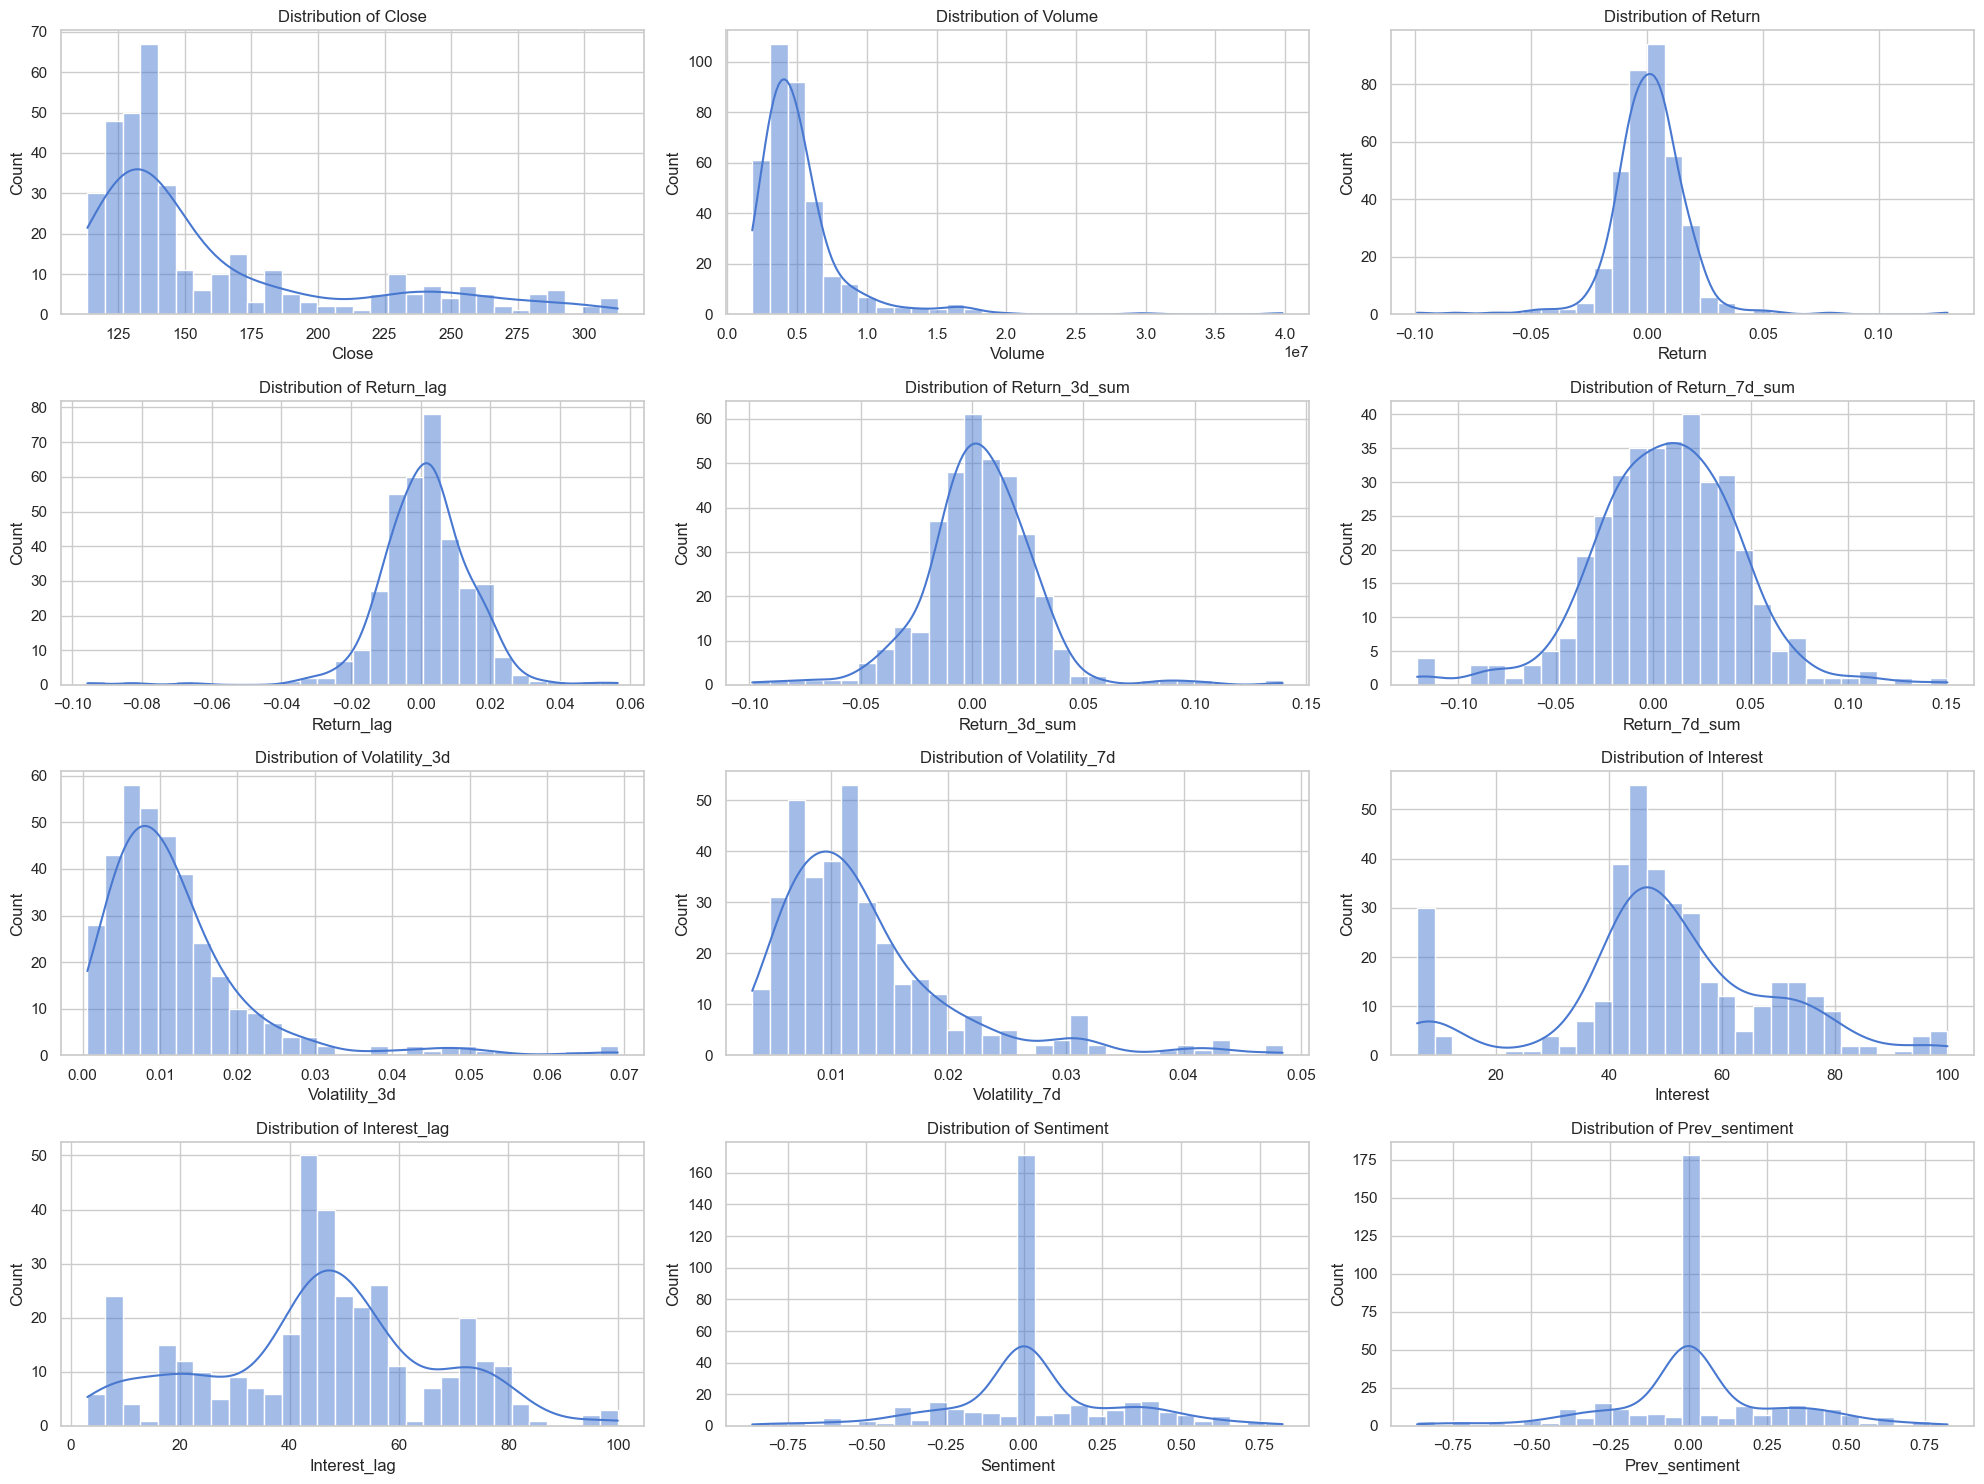

In [9]:
variables = ['Close', 'Volume', 'Return', 'Return_lag', 'Return_3d_sum', 'Return_7d_sum',
             'Volatility_3d', 'Volatility_7d', 'Interest', 'Interest_lag', 'Sentiment', 'Prev_sentiment']

# Distributions of variables 
plt.figure(figsize=(20,15))
for i, var in enumerate(variables, 1):
    plt.subplot(4,3,i)
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()
plt.close()

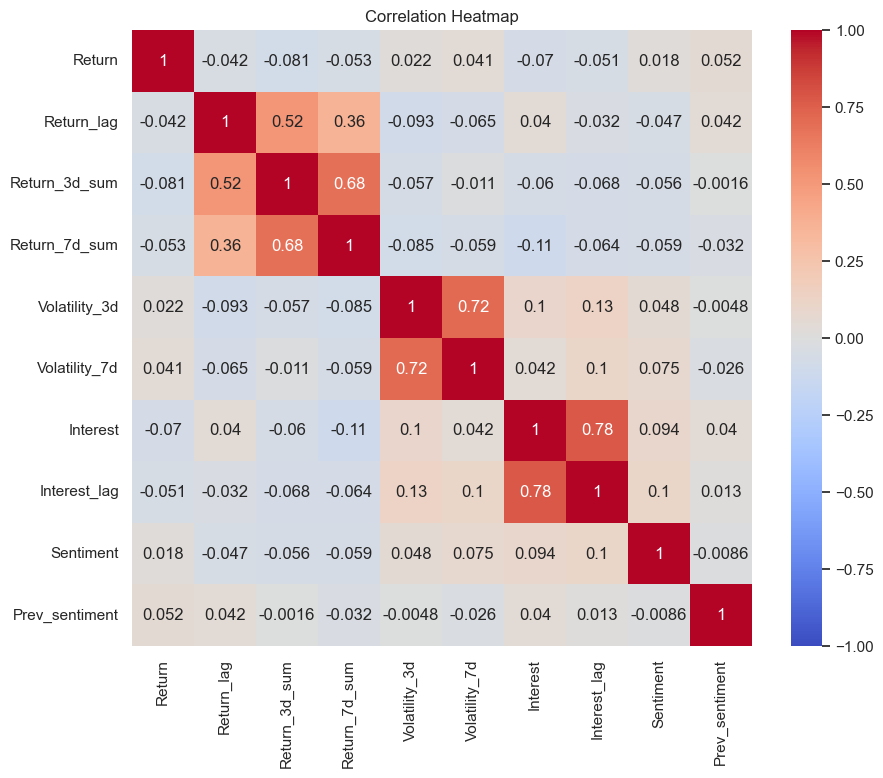

In [11]:
# Correlation heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df[variables].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()
plt.close()

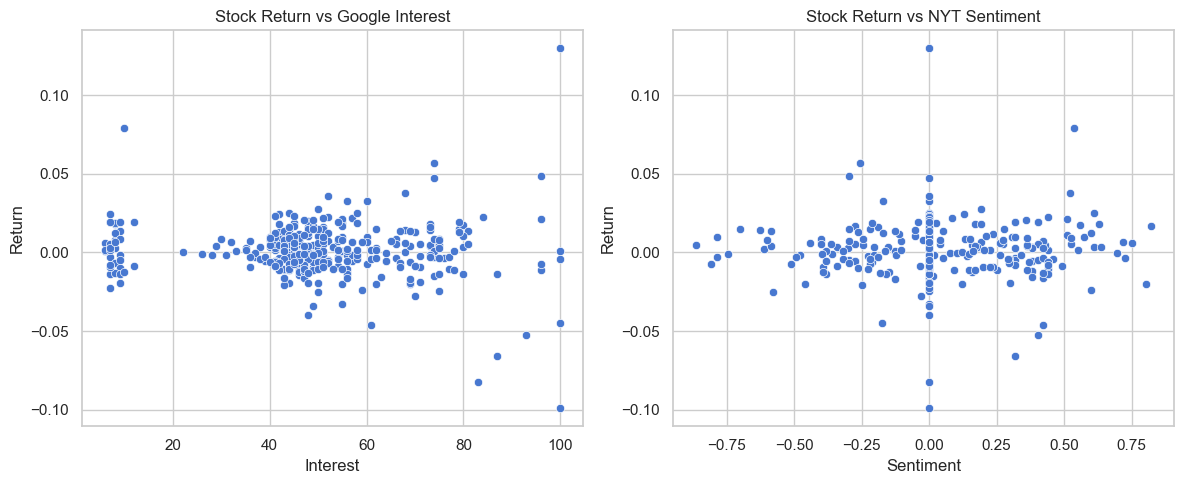

In [12]:
# Explore Interest and Sentiment Shapes

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)  # Return vs Google Interest
sns.scatterplot(x='Interest', y='Return', data=df)
plt.title('Stock Return vs Google Interest')
plt.subplot(1,2,2)  # Return vs NYT Sentiment
sns.scatterplot(x='Sentiment', y='Return', data=df)
plt.title('Stock Return vs NYT Sentiment')
plt.tight_layout()
plt.show()
plt.close()

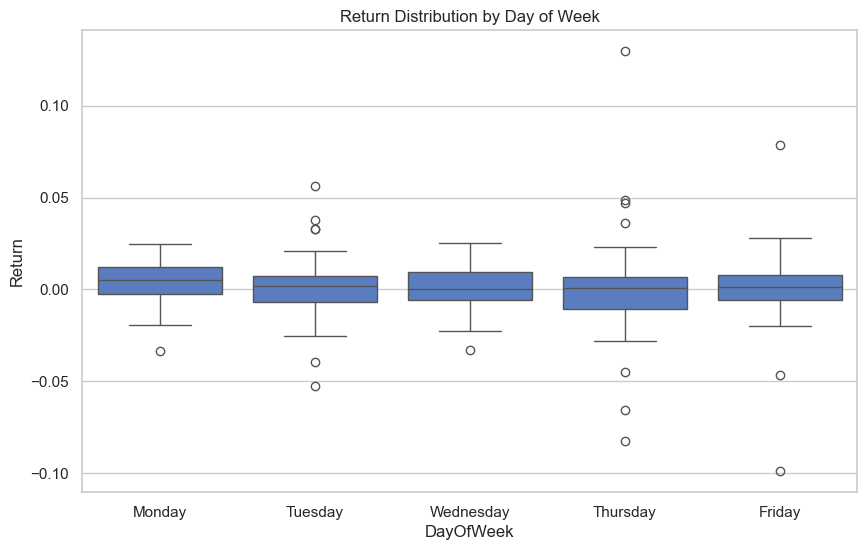

In [13]:
# Day of the Week 

plt.figure(figsize=(10,6))
sns.boxplot(x='DayOfWeek', y='Return', data=df,
            order=['Monday','Tuesday','Wednesday','Thursday','Friday'])
plt.title("Return Distribution by Day of Week")
plt.show()
plt.close()

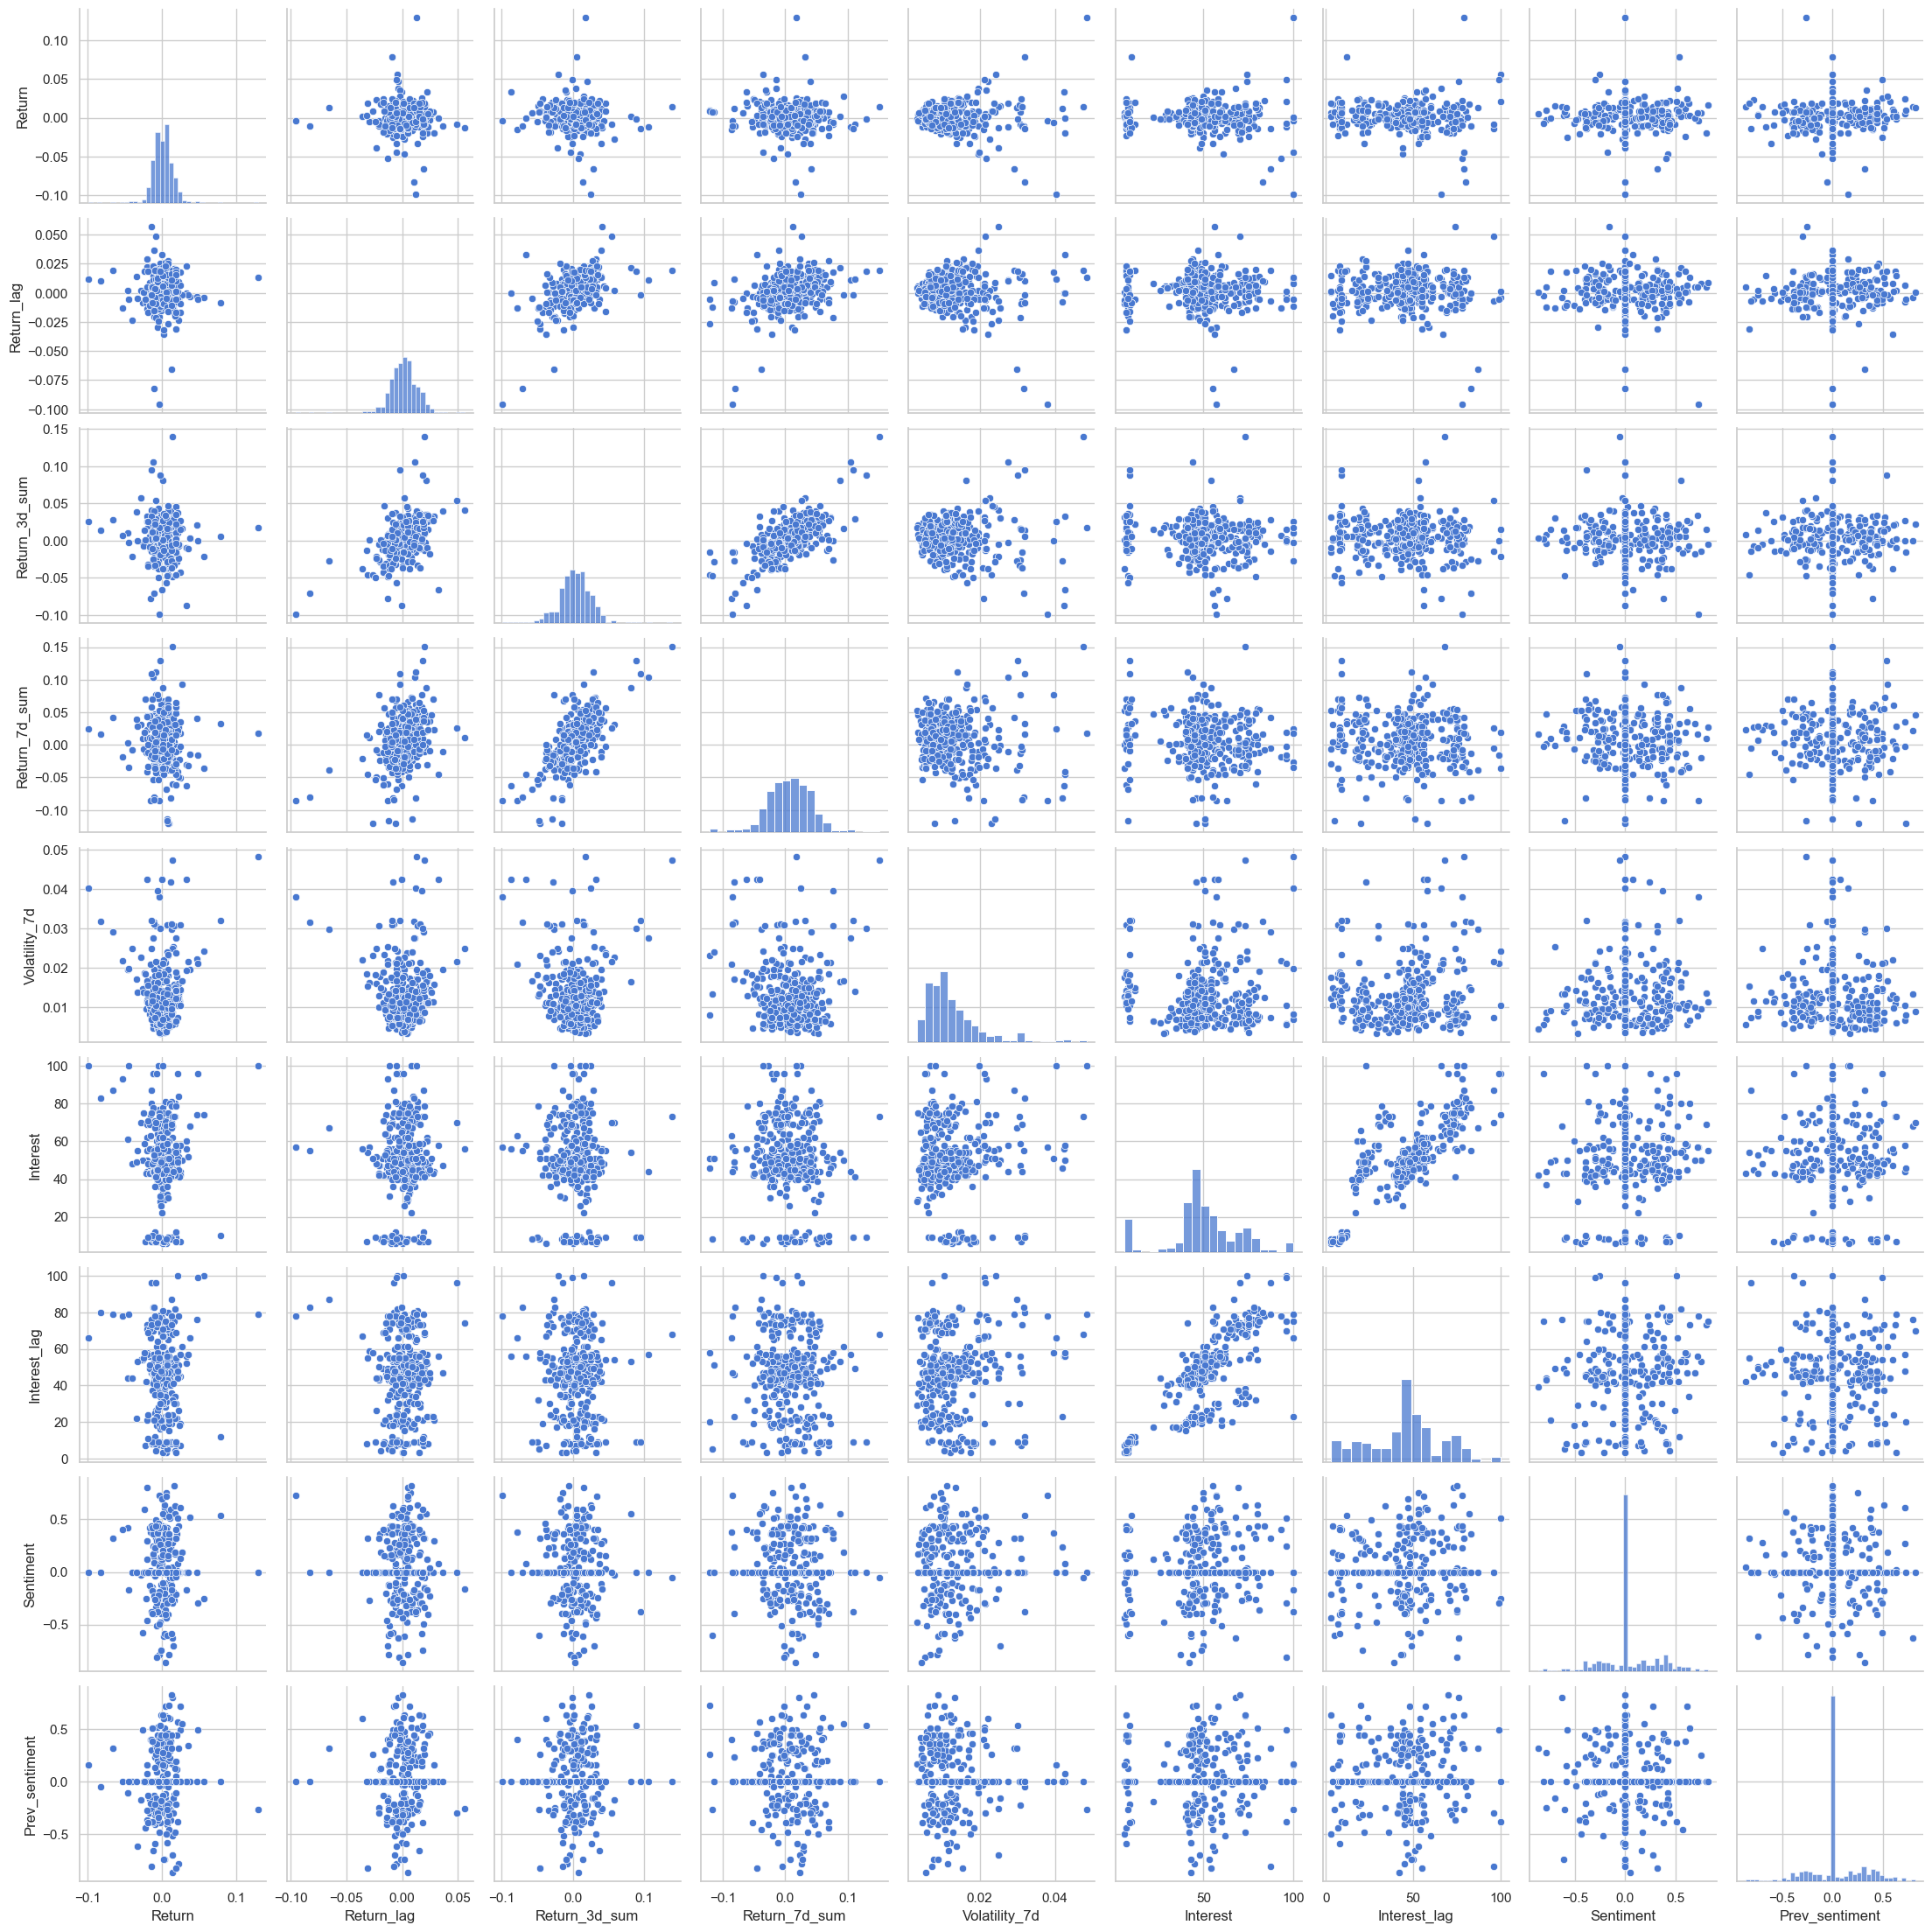

In [14]:
# Pairplot for relationships

sns.pairplot(df[['Return', 'Return_lag', 'Return_3d_sum', 'Return_7d_sum', 'Volatility_7d', 
                 'Interest', 'Interest_lag', 'Sentiment', 'Prev_sentiment']])
plt.show()
plt.close()

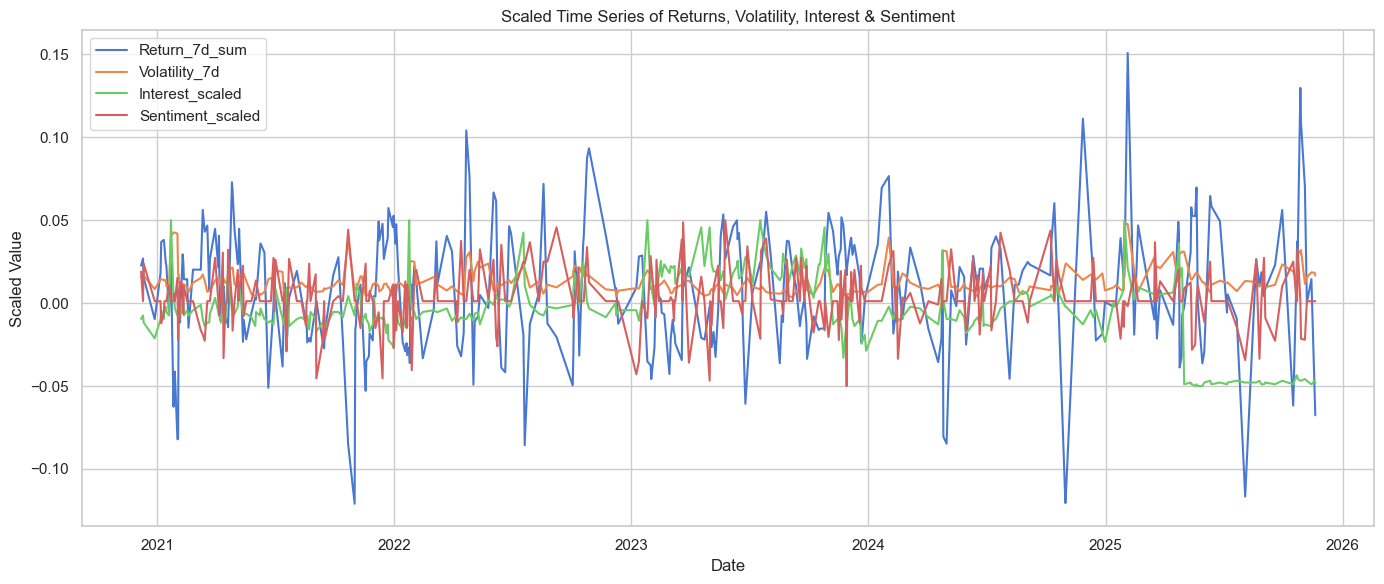

In [26]:
# Time Series

# Scale vars
def scale_series(series, new_min=-0.05, new_max=0.05):
    s_min = series.min()
    s_max = series.max()
    return (series - s_min) / (s_max - s_min) * (new_max - new_min) + new_min

df['Return_scaled'] = scale_series(df['Return'])
df['Interest_scaled'] = scale_series(df['Interest'])
df['Sentiment_scaled'] = scale_series(df['Sentiment'])

# Plot
df_to_plot = ['Return_7d_sum', 'Volatility_7d', 'Interest_scaled', 'Sentiment_scaled']
plt.figure(figsize=(14,6))
for col in df_to_plot:
    plt.plot(df['Date'], df.get(col, df[col]), label=col)
plt.title("Scaled Time Series of Returns, Volatility, Interest & Sentiment")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


Modeling 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

In [18]:
# a return under threshold is labeled not up
threshold = 0.005

# define prediction variable
df["Target"] = (df["Return"] > threshold).astype(int)

In [19]:
# Only inlcude variables that are known that day 
features = [
    "Return_lag",
    "Return_3d_sum",
    "Return_7d_sum",
    "Volatility_3d",
    "Volatility_7d",
    "Interest_lag",
    'Prev_sentiment'
]

X = df[features]
y = df["Target"]

In [20]:
# train-test split

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [21]:
# Scale

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Handle imbalance in classes (for logistic reg, naive bayes and KNN)

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))

In [23]:
# Models to be tested

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight=class_weight_dict
    ),

    "Ridge Classifier": RidgeClassifier(),  
    
    "Naive Bayes": GaussianNB(),
    
    "KNN Classifier": KNeighborsClassifier(n_neighbors=5),
}

In [24]:
# Train deploy, & evaluate model

model_names = []
f1_minority_scores = []
accuracy_scores = []

for name, model in models.items():
    print(f"{name}:")
    
    # models that require scaling
    if name in ["Logistic Regression", "Ridge Classifier", "KNN Classifier"]:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    f1_minority = f1_score(y_test, y_pred, pos_label=0)
    acc = accuracy_score(y_test, y_pred)

    print(f"f1-score (Stock not up): {f1_minority:.4f}")
    print("Preformance Metrics:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    model_names.append(name)
    f1_minority_scores.append(f1_minority)
    accuracy_scores.append(acc)

Logistic Regression:
f1-score (Stock not up): 0.4127
Preformance Metrics:
              precision    recall  f1-score   support

           0     0.4815    0.3611    0.4127        36
           1     0.4889    0.6111    0.5432        36

    accuracy                         0.4861        72
   macro avg     0.4852    0.4861    0.4780        72
weighted avg     0.4852    0.4861    0.4780        72

Confusion Matrix:
[[13 23]
 [14 22]]
Ridge Classifier:
f1-score (Stock not up): 0.6600
Preformance Metrics:
              precision    recall  f1-score   support

           0     0.5156    0.9167    0.6600        36
           1     0.6250    0.1389    0.2273        36

    accuracy                         0.5278        72
   macro avg     0.5703    0.5278    0.4436        72
weighted avg     0.5703    0.5278    0.4436        72

Confusion Matrix:
[[33  3]
 [31  5]]
Naive Bayes:
f1-score (Stock not up): 0.5610
Preformance Metrics:
              precision    recall  f1-score   support

      

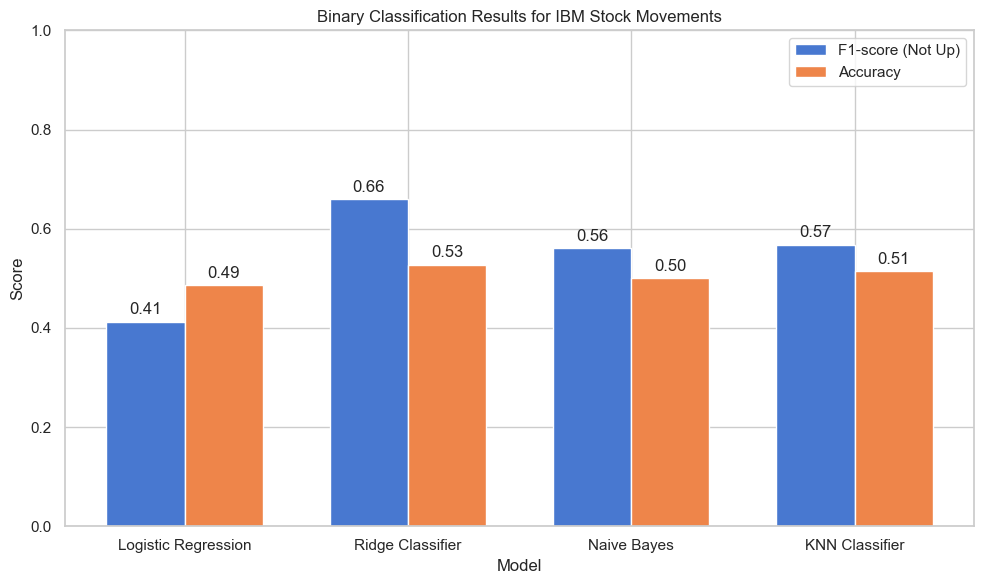

In [25]:
# Bar plot of results

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(model_names))

bars1 = ax.bar(index, f1_minority_scores, bar_width, label='F1-score (Not Up)')
bars2 = ax.bar([i + bar_width for i in index], accuracy_scores, bar_width, label='Accuracy')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Binary Classification Results for IBM Stock Movements')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.legend()

# Annotate
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.annotate(
            f'{h:.2f}', 
            xy=(bar.get_x() + bar.get_width() / 2, h),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom'
        )

plt.tight_layout()
plt.show()